# Búsqueda bidireccional

El algoritmo de búsqueda bidireccional busca reducri la complejidad de la búsqueda al realizar dos búsquedas de manera simultánea: 1) una búsqueda desde el estado inicial hasta el estado final; y 2) una búsqueda desde el estado final hasta el inicial. El algoritmo determinará en qué puntos ambas búsquedas coinciden y de esta forma, uniendo ambos caminos, dará una solución final.

Aquí implementamos una búsqueda bidireccional en base a $A^*$ para solucionar el problema del laberinto.

### Creación del problema

Una de las desventajas de la búsqueda bidireccional es que requiere definir dos problemas de búsqueda: uno para el avance y otro para el retroceso. El problema de avance es el problema original, donde buscamos llegar de un estado inicial a uno final. El problema de retroceso corresponde a la versión invertida de este problema, aquí se parte de lo que originalemente era el estado final y se busca llegar al estado inicial original. 

En el caso del problema del laberinto, generar estos problemas es sencillo, pues sólo debemos cambiar los indicadores de incio y meta dentro del mapa. De esta forma, podemos ver que los problemas obtenidos son similares, pero con la meta y el inicial invertidos.

Problema de avance


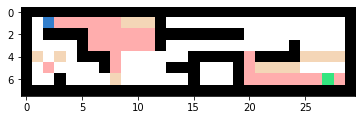

Estado inicial: (2, 1)
Estado final: (27, 6)

Problema de retroceso


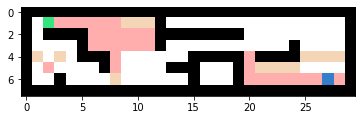

Estado inicial: (27, 6)
Estado final: (2, 1)


In [1]:
import numpy as np
from maze_simulator import TrafficMaze

forward_map = """
##############################
# o------...#                #
# ####------########         #
#    #------#           #    #
#. . ###-      #####-####....#
# -    #-    ###   #-....    #
#  #    .      #   #-------x-#
##############################
"""
backward_map = """
##############################
# x------...#                #
# ####------########         #
#    #------#           #    #
#. . ###-      #####-####....#
# -    #-    ###   #-....    #
#  #    .      #   #-------o-#
##############################
"""

forward = TrafficMaze(forward_map)
print('Problema de avance')
forward.draw()
print('Estado inicial: {}\nEstado final: {}'.format(forward.initial, forward.goal))

backward = TrafficMaze(backward_map)
print('\nProblema de retroceso')
backward.draw()
print('Estado inicial: {}\nEstado final: {}'.format(backward.initial, backward.goal))

## Heurística

Cuando tenemos un algoritmo de búsqueda bidireccional que ocupa una función heurístca más una función de costo, podemos ver que tenemos dos funciones de prioridad, $f_F$ y $f_B$ para el problema de avance y de retroceso, respectivamente. En el caso del avance la función está dada por:

$$f_F(n) = g_F(n) + h_F(n)$$

Mientras que para el retroceso tenemos algos similar:

$$f_F(n) = g_F(n) + h_F(n)$$

Tanto las funciones de costo como las heurísticas no tienen, en principio, que ser iguales. Por ejemplo, una heurística basada en distancias no será la misma en ambas direcciones, pues la distancia a la meta cambia en tanto cambia la meta.

En este caso, utilizaremos la heurística de distancia euclideana para ambos problemas. Sólo debe tomarse en cuenta que en cada caso, el punto meta con respecto al cual se toma la métrica varía.

In [2]:
def h(state, goal,p=2):
    """Heurísitca euclideana"""
    x1,y1 = state
    x2,y2 = goal
    #Obtiene distancia euclideana
    dist = ((x2-x1)**p + (y2-y1)**p)**(1/p)
    
    return dist.real

## Construcción del algoritmo

El algoritmo tomará en cuenta ambos problemas y realziará dos búsquedas de manera paralela hasta coincidir. En cada búsqueda se creará un árbol de búsqueda. Por tanto, necesitamos definir la pila de prioridad que se utilizará en cada búsqueda, así como los objetos nodos y una función de expansión.

In [3]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda."""
    def __init__(self,f=lambda x: 1):
        self.queue = []
        self.f = f
  
    def __str__(self):
        return ' '.join([str(q) for q in self.queue])
  
    def isEmpty(self):
        return self.queue == []
  
    def push(self, element):
        """Agrega elementos a la pila"""
        self.queue.append(element)
  
    def pop(self):
        """Saca de la pila el elemento con mayor valor f."""
        #Encuentra el elemento máximo en base al costo
        min_element = np.argmin([element.f for element in self.queue])
        #Guarda el elemento máximo
        item = self.queue[min_element]
        #Borra este elemento de la cola
        del self.queue[min_element]
    
        return item
    
    def top(self):
        "Muestra útlitmo elemento po salir"
        min_element = np.argmin([element.f for element in self.queue])
        return self.queue[min_element]

### Nodos y expansión

Los nodos serán de la misma forma en que los hemos estado definiendo. En la expansión falta hacer algunas aclaraciones.

Podemos notar que si $m$ es nodo en el camino de avance y $n$ en el de retroceso (asumiendo que ambas heurísticas son admisibles), podemos observar que:

$$\max\{g_F(m)+g_B(n), f_F(m), f_B(n)\} = lb(m,n) < C^*$$

Donde $C^*$ es el costo del camino óptimo y $lb(m,n)$ es por tanto una cota inferior. Ya que estamos usando problemas de avance y retroces que son  en su mayor parte similares, podemos pensar que estas funciones comparten ciertos valores similares.

En particular, se debe notar que el costo por acción es el mismo en ambos problemas, pues el costo depende del tráfico y no de la dirección de este. Entonces, si tenemos un camino de avance, si este fuera el mismo camino de retroceso, el costo sería el mismo. Por tanto, $g_F(n) = g_B(n)$, con la única salvedad de que el nodo inicial es el que puede variar en ambos casos.

De igual forma, podemos ver que la heurística es la similar, exceptuando que se calcula sobre una meta distinta. Pero esto no afectará en gran medida a nuestros cálculos. En general, observaremos que el primer término $g_F(m)+g_B(n) = 2g(n)$, pues asumimos su igualdad. Asimismo, asuminedo que las funciones heurísticas son similares, basta con poner una función de prioridad en el máximo, lo que nos dará la función de prioridad para la búsqueda heurística bidireccional:

$$f(n) = \max\{2g(n), g(n) + h(n)\}$$

Y esta es la función que utilizaremos para crear los nodos, y como función dentro de la pila de prioridad.

In [4]:
class Node(object):
    """Clase para crear nodos con sus atributos."""
    def __init__(self):
        self.state = (0,0)
        self.parent = None 
        self.action = None
        self.cost = 0
        self.f = 0
        
    def __str__(self):
        return str(self.state)
            
def expand(problem, node):
    """Función para expandir los nodos dado el problema"""
    s = node.state 
    for action in problem.actions(s):
        #Aplica la función de resultado
        new_s = problem.result(s, action)
        #Crea el nuevo nodo
        new_node,new_node.state,new_node.parent,new_node.action = Node(),new_s,node,action
        #Agrega el costo
        new_node.cost = node.cost + problem.cost(s,action,new_s)
        #Agrega sólo la heurística al nodo
        new_node.f = max( 2*new_node.cost, new_node.cost + h(new_s, problem.goal) )
        
        yield new_node

### Creación de los árboles de búsqueda

Como lo señalamos, el algoritmo de búsqueda heurística bidireccional tomará en cuenta dos procesos de búsqueda; por tanto conviene definir una función que se utilice en ambos procesos para no crear código de más. Esta función la llamamos <tt>proceed</tt> y realiza precisamente los pasos de la expansión de nodos y agreagación de estos a la frontera. Pero además revisará si en algún punto las búsquedas coinciden, pues si es así, podríamos unir ambas búsquedas en este punto para tener una solución final.

Los pasos que la función <tt>procees</tt> realizará son los siguientes:

1. Hará pop sobre la frontera tomando el nodo de mayor prioridad primero.
2. Expandirá el nodo para obtener los hijos de éste.
3. Por cada hijo guardará el estado que representa.
4. Revisa si el nodo no ha sido alcanzado o bien si su costo es menor, de tal forma que lo agregue a la frontera.
5. Revisará si el estado de este nodo ya ha sido alcanzado en la otra búsqueda, si es así:
    1. Revisa si está en la búsqueda de avance, para crear una solución uniendo ambas búsquedas.
    2. Revisa si está en la búsqueda de retroceso, para crear una solución uniendo ambas búsquedas.
6. En cualquier caso, si la solución que obtiene es mejor que la solución anterior, obtará por esta última solución.

In [5]:
def path_cost(solution):
    """Función para obtener costo de camino"""
    if solution == 'failure':
        return np.inf
    else:
        return sum([n.cost for n  in solution[0]])+sum([n.cost for n  in solution[1]])
               
def get_path(leaf, path=[]):
    """Función para recuperar el camino de un nodo"""
    if leaf.parent == None:
        return [leaf]+path
    else:
        return get_path(leaf.parent, path=[leaf]+path)

def proceed(d, problem, frontier, reached, reached2, solution):
    """Función que genera árbol tanto en forward como en backward"""
    node = frontier.pop()
    #Expande los nodos
    for child in expand(problem, node):
        s = child.state
        #Si no han sido alcanzado o su costo es menor
        if s not in reached or child.f < reached[s].f:
            #Se agregan
            reached[s] = child
            frontier.push(child)
            
            #Condiciones para revisar la coincidencia de caminos
            if s in reached2:
                #Si el nodo ya ha sido alcanzado en el otro problema
                if d == 'F':
                    #Genera la solución de avance
                    path_f = get_path(child)
                    path_b = get_path(reached2[s])                          
                    solution2 = (path_f, path_b)
                    
                    #Actualiza la solución si su costo es menor
                    if path_cost(solution2) < path_cost(solution):
                        solution = solution2
                else:
                    #Genera la solución de retriceso
                    path_b = get_path(child)
                    path_f = get_path(reached2[s])
                    solution2 = (path_f, path_b)
                    
                    #Actualiza la solución si su costo es menor
                    if path_cost(solution2) < path_cost(solution):
                        solution = solution2
            
    return solution

### Algoritmo

Finalmente, el algoritmo de búsqueda heurística bidireccional tomará como entrada el problema de avance y el de retroceso. Para cada uno de estos problemas guardará el estado inicial, creará una frontera para cada uno y guardará los nodos alcanzados en cada problema.

Posteriormente procederá a comparar las búsquedas, aplicando la función de <tt>proceed</tt>, que hemos referido arriba, a la frontera del problema que tenga menor valor. De esta forma, cuando encuentre una coincidencia entre ambos problemas regresará la solución, que aquí hemos dividido en dos partes, y en otro caso fallará.

In [6]:
def bidirectional(forward, backward):
    """Algoritmo bidireccional para generar el camino más apto"""
    #Nodo inicial
    node_f, node_b = Node(), Node()
    node_f.state, node_b.state = forward.initial, backward.initial
    #Frontera con cola de prioridad
    frontier_f, frontier_b = PriorityQueue(), PriorityQueue()
    frontier_f.push(node_f)
    frontier_b.push(node_b)
    #Nodos alcanzados
    reached_f, reached_b = {forward.initial:node_f}, {backward.initial:node_b}
    #Solución
    solution = 'failure'
    
    #Mientras la frontera no esté vacía
    while not frontier_f.isEmpty() and not frontier_b.isEmpty():
        if frontier_f.top().f < frontier_b.top().f:
            solution = proceed('F', forward, frontier_f, reached_f, reached_b, solution)
        else:
            solution =  proceed('B', backward, frontier_b, reached_b, reached_f, solution)

    return solution

### Aplicación del algoritmo

Ahora que hemos definido el algoritmo, y hemos definido tanto el problema de avance como el de retroceso, podemos aplicar el algoritmo bidireccional para obtener una solución. En nuestro caso, la solución constará de dos partes: la parte de avance y la de retroceso. La solución final será unir estas dos partes por el punto intermedio.

In [7]:
tree_f, tree_b = bidirectional(forward, backward)

Cuando visualizamos ambas soluciones podemos entender mejor lo que hace el algoritmo:

Solución Forward


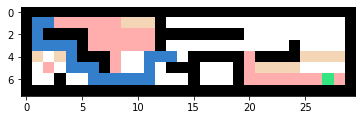

Costo total: 21
Solución Backward


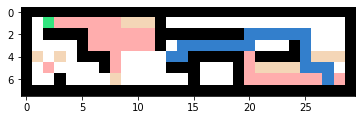

Costo total: 21


In [8]:
#Visualiza la solución
prev_s = forward.initial
for n in tree_f:
    forward.move(prev_s, n.state)
    prev_s = n.state

print('Solución Forward')
forward.draw()
print('Costo total: {}'.format(tree_f[-1].cost))

#Visualiza la solución
prev_s = backward.initial
for n in tree_b:#get_path(tree_b[1], backward.initial):
    backward.move(prev_s, n.state)
    prev_s = n.state

print('Solución Backward')
backward.draw()
print('Costo total: {}'.format(tree_b[-1].cost))

Como podemos ver, una parte de la búsqueda final, responde al paso de avance, mientras que la otra a la de retroceso. Pero es claro que ambos caminos coinciden en un punto intermedio. Al unir los caminos por este punto intermedio obtendremos la solución al problema original.